In [1]:
import numpy as np 
from sympy import *
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.stats import binned_statistic, describe

import sys
sys.path.append('../../src/')
from aDNA_coal_sim import *
from plot_utils import *

%matplotlib inline

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True
plt.rcParams['pdf.fonttype'] = 3
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
main_figdir = '../../plots/jointLD_stats/'
supp_figdir = '../../plots/supp_figs/jointLD_stats/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

## Deriving the joint LD statistics

In [3]:
# Define variables in sympy... 
rho,t,eta,gamma = symbols('rho t \eta \gamma')

gamma = rho*(1  - exp(-t *(rho/2 + 1)))/(rho + 2)
eta = 2*(1  - exp(-t *(rho/2 + 1)))/(rho + 2)

eT_AT_B_200 = (rho**2 + 14*rho + 36)/(rho**2 + 13*rho + 18)
eT_AT_B_111 = (rho**2 + 13*rho + 24)/(rho**2 + 13*rho + 18)
eT_AT_B_022 = (rho**2 + 13*rho + 22)/(rho**2 + 13*rho + 18)

In [4]:
# Defining the staggered statistics (from the note)
e_TATB_200_anc = (1 - gamma)*eT_AT_B_200 + gamma*eT_AT_B_111
e_TATB_022_anc = (1 - eta).simplify() * eT_AT_B_022 + eta*eT_AT_B_111
e_TATB_111_mod_coupled = (1-gamma)*eT_AT_B_111 + gamma*eT_AT_B_022
e_TATB_111_mod_uncoupled = (1-eta)*eT_AT_B_111 + eta*eT_AT_B_200

# Simplifying the statistics
e_TATB_200_anc = e_TATB_200_anc.factor().simplify()
e_TATB_022_anc = e_TATB_022_anc.factor().simplify()
e_TATB_111_mod_coupled = e_TATB_111_mod_coupled.factor().simplify()
e_TATB_111_mod_uncoupled = e_TATB_111_mod_uncoupled.factor().simplify()


e_TATB_022_anc

(rho**3*exp(t*(rho + 2)/2) + 15*rho**2*exp(t*(rho + 2)/2) + 48*rho*exp(t*(rho + 2)/2) + 48*exp(t*(rho + 2)/2) - 4)*exp(-t*(rho + 2)/2)/((rho + 2)*(rho**2 + 13*rho + 18))

In [5]:
eD0DT_numerator = (e_TATB_200_anc - e_TATB_111_mod_coupled - e_TATB_111_mod_uncoupled + e_TATB_022_anc)

e_D0DT_numerator = eD0DT_numerator.factor().simplify()
e_D0DT_numerator

(rho + 10)*exp(-t*(rho + 2)/2)/(rho**2 + 13*rho + 18)

In [6]:
e_D0Dt_norm = e_D0DT_numerator / e_TATB_022_anc
e_D0Dt_norm # Note this does not actually go "negative"

(rho + 2)*(rho + 10)/(rho**3*exp(t*(rho + 2)/2) + 15*rho**2*exp(t*(rho + 2)/2) + 48*rho*exp(t*(rho + 2)/2) + 48*exp(t*(rho + 2)/2) - 4)

100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


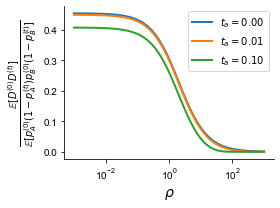

In [7]:
def eD0Dt_norm_eval(r,ta):
    """Function just to evaluate the expression..."""
    return(e_D0Dt_norm.evalf(subs={rho: r, t:ta}))

fig, ax = plt.subplots(1,1,figsize=(4,3))
rhos = np.logspace(-3, 3, 50)
tas = [0, 1e-2, 1e-1]
for ta in tqdm(tas):
    cur_d0dt_norm = np.array([eD0Dt_norm_eval(r,ta) for r in rhos])
    ax.plot(rhos, cur_d0dt_norm, lw=2, label=r'$t_a = %0.2f$' % ta)
    
ax.legend(fontsize=10)
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$', fontsize=14)
ax.set_ylabel(r'$\frac{\mathbb{E}[D^{(0)}D^{(t)}]}{\mathbb{E}[p^{(0)}_A(1 - p^{(t)}_A)p_B^{(0)}(1 - p_B^{(t)}]}$', fontsize=14)
debox(ax);
plt.savefig(main_figdir + 'eD0Dt_theory.pdf', dpi=300, bbox_inches='tight')

## Corroborating theory w/ simulation results

In [8]:
ld_raw_df = pd.read_csv('../../results/ld_stats_raw/ld_stats_time_sep_raw_maf5.csv.gz')
ld_raw_df.head()

,ed0dt,std_ed0dt,rec_dist,ta,scenario,seed
0,0.213080,0.288249,0.000061,0,SerialConstant,11
1,0.096555,0.148710,0.000183,0,SerialConstant,11
2,0.067565,0.114702,0.000305,0,SerialConstant,11
3,0.050964,0.087273,0.000427,0,SerialConstant,11
4,0.043060,0.076167,0.000549,0,SerialConstant,11


100%|██████████| 3/3 [00:18<00:00,  6.25s/it]


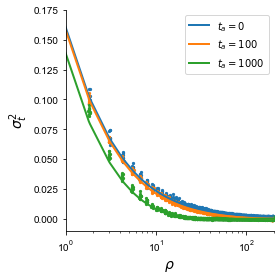

In [9]:
# NOTE: variable names are kind of wonky 
fig, ax = plt.subplots(1,1,figsize=(4,4))
for x in tqdm([0,100, 1000]):
    ld_raw_df_filt = ld_raw_df[(ld_raw_df['ta'] == x)]
    ax.scatter(ld_raw_df_filt.rec_dist*1e4, ld_raw_df_filt.ed0dt, s=5)
    z = x/10000
    # Dealing with some rescaling between sims vs. theory (factors of two here ... )
    cur_d0dt_norm = np.array([eD0Dt_norm_eval(y,z/2) for y in np.unique(ld_raw_df_filt.rec_dist*1e4*4)])
    ax.plot(np.unique(ld_raw_df_filt.rec_dist*1e4), cur_d0dt_norm, lw=2, label=r'$t_a = %d$' % int(z*1e4))
    
ax.legend()
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$', fontsize=14)
ax.set_ylabel(r'$\sigma^2_t$', fontsize=14)
debox(ax);
ax.set_xlim(1, 2e2)
ax.set_ylim(-0.01,0.175)
plt.savefig(main_figdir + 'eD0Dt_theory_sims.pdf', dpi=300, bbox_inches='tight')

## Checking for bias in estimation of $\sigma^2_t$

In [19]:
ld_bias_df = pd.read_csv('../../results/ld_stats_raw/ld_stats_time_sep_raw_verify_bias.csv.gz')
ld_bias_df.head()

,ed0dt,std_ed0dt,rec_dist,ta,scenario,maf,seed
0,0.014290,0.048017,0.002454,0,SerialConstant,0.01,1
1,0.003407,0.010981,0.007342,0,SerialConstant,0.01,1
2,0.021475,0.060987,0.002424,0,SerialConstant,0.05,1
3,0.003216,0.007101,0.007353,0,SerialConstant,0.05,1
4,0.015820,0.053408,0.002427,0,SerialConstant,0.01,2


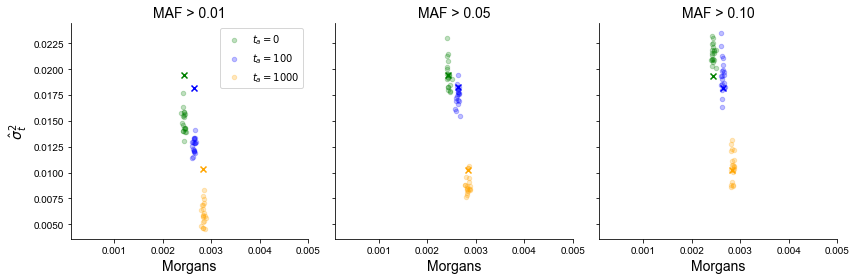

In [70]:
ld_bias_df = pd.read_csv('../../results/ld_stats_raw/ld_stats_time_sep_raw_verify_bias.csv.gz')

def eD0Dt_norm_test(r,t):
    """ Revamped version of that function ... """
    return(((r+2)*(r+10))/((r**3 + 15*r**2 + 48*r + 48)*np.exp(t*(r+2)/2) - 4.0))

ts = np.unique(ld_bias_df.ta.values)
unique_mafs = np.unique(ld_bias_df.maf.values)

fig, ax = plt.subplots(1,unique_mafs.size, figsize=(4*unique_mafs.size,4), sharex=True, sharey=True)
for j,maf in enumerate(unique_mafs):
    ld_bias_df_filt = ld_bias_df[ld_bias_df.maf == maf]
    color=['green','blue','orange']
    for i,t in enumerate(ts):
        cur_filt_df = ld_bias_df_filt[(ld_bias_df_filt.ta == t) & (ld_bias_df_filt.rec_dist <= 5e-3) & (ld_bias_df_filt.rec_dist >= 1e-4)]
        ax[j].scatter(cur_filt_df.rec_dist+(i*2e-4), cur_filt_df.ed0dt, s=20, color=color[i], alpha=0.25, label=r'$t_a = %d$' % int(t))
        r = np.mean(cur_filt_df.rec_dist)*1e4*2
        cur_d0dt_norm = np.array([eD0Dt_norm_test(r, (t/1e4/4))])
        ax[j].scatter(np.mean(cur_filt_df.rec_dist)+(i*2e-4), cur_d0dt_norm, color=color[i], marker='x')
        ax[j].set_xlabel(r'Morgans', fontsize=14)
    ax[j].set_title(r'MAF > %0.2f' % maf, fontsize=14)

ax[0].legend()
ax[0].set_xlim(1e-4, 5e-3)
# ax.set_ylim(-0.01,0.01)
debox_all(ax);
ax[0].set_ylabel(r'$\hat{\sigma}^2_t$', fontsize=14)
plt.tight_layout()